This notebook should be run in colab setting: before running through the cells, the processed dataset 'bg_struct.csv' should be imported to google drive colab and the corresponding path of dataset should be updated. 

In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In this notebook, a deep learning with neural network structure model is trained to predict the relationship between ['cell_length_a', 'cell_lentgh_b', 'cell_lentgh_c', 'cell_angle_alpha', 'cell_angle_beta', 'cell_angle_gamma'] and ['bandgap'] of the data. After extensive tuning and testing, the resulting neural network model achieves a test accurary of 84.74%.

For comparative study, k-means clustering is performed on the dataset. During preprocessing, each datapoint is classified to a class depending on the ['bandgap'] value. And total number of classes to be assigned to is the hyperparameter k in the k-means clustering to be tuned. After hyper-parameter tuning, 3 classes would give the highest classification accurary of 10.8% in test set. 

If I adopt this class assignment on the ['bandgap'] value and use one-hot encoding on the class label, the neural network classifier gives a classification accurary of 36.7% in test set, despite large amount of training and tuning efforts. 

Therefore, we can conclude that although the training can bring the training cost down, the results of deep learning for both regression and classification tasks are very negative. A potential cause is that the correlation between the ['cell_length_a', 'cell_lentgh_b', 'cell_lentgh_c', 'cell_angle_alpha', 'cell_angle_beta', 'cell_angle_gamma'] and ['bandgap'] of the data is weak. Also, the current class encoding is not supported by any domain knowledge: it's very likely that the class assignment is not linear in the value of ['bandgap'] that we are unable to capture. 

In [2]:
# Import plotting libraries
import matplotlib 
from matplotlib import pyplot as plt
matplotlib.rcParams.update({'font.size': 20})
plt.rcParams.update({'font.size': 22})

import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch import linalg as LA
import tensorflow
from sklearn.cluster import KMeans

import torch
import torch.nn as nn
import torch.nn.functional as F


%load_ext autoreload
%autoreload 2


## load and preprocess the data for training

In [3]:

data = pd.read_csv('/content/bg_struct.csv')
X = data[['cell_length_a', 'cell_lentgh_b', 'cell_lentgh_c', 'cell_angle_alpha', 'cell_angle_beta', 'cell_angle_gamma']].values
Y = data[['bandgap']].values

In [4]:
seed = 12
# create test/train split from the data above and  keep 10% for testing
X_train_pn, X_test_pn, y_train, y_test = train_test_split(X, Y,
                                                         test_size=0.1, 
                                                         random_state=seed)

# train a standard scaler model to apply it to the train set and test set
X_train_scaler = StandardScaler().fit(X_train_pn)
X_train = X_train_scaler.transform(X_train_pn).astype(np.float32)
X_test = X_train_scaler.transform(X_test_pn).astype(np.float32)


## Supervised learning to explore the relationship between ['cell_length_a', 'cell_lentgh_b', 'cell_lentgh_c', 'cell_angle_alpha', 'cell_angle_beta', 'cell_angle_gamma'] and ['bandgap']

In [5]:
x_data = torch.tensor(X_train)
y_data = torch.tensor(y_train.astype(np.float32))

x_test = torch.tensor(X_test)
y_test = torch.tensor(y_test.astype(np.float32))

In [6]:
#construct the neural network architecture
class Net(nn.Module):
    def __init__(self, input_size):
      super(Net, self).__init__()
      self.fc1 = nn.Linear(input_size, 32)
      self.fc2 = nn.Linear(32, 16)
      self.fc3 = nn.Linear(16, 16)
      self.fc4 = nn.Linear(16, 1)       
      self.dropout1 = nn.Dropout(p=0.1)

    def forward(self, x):
      x = self.fc1(x)
      F.relu(x)
      x = self.fc2(x)
      x = self.fc3(x)
      x = F.relu(x)
      x = self.fc4(x)

      return x


In [7]:
my_nn = Net(6)
loss_fn = nn.MSELoss()
epoch_loss = []
model = my_nn
learning_rate = 0.02
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=0.65)
for t in range(1000):
    y_pred = model(x_data)
    loss = loss_fn(y_pred, y_data)
    epoch_loss.append(loss.item())
    if t % 100 == 99:
        print(t, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
test_result = my_nn(x_test)


99 0.2655410170555115
199 0.1439744532108307
299 0.1399437040090561
399 0.13953472673892975
499 0.1399371474981308
599 0.15179136395454407
699 0.13897132873535156
799 0.13910451531410217
899 0.15023453533649445
999 0.13900503516197205


In [8]:
print("curr test accuracy is=", str(1 - LA.norm(y_test-test_result)/LA.norm(y_test)))

curr test accuracy is= tensor(0.8475, grad_fn=<RsubBackward1>)


visualize the training curve: the initial noise is cut off for better visualization

Text(0.5, 1.0, 'training loss iteration')

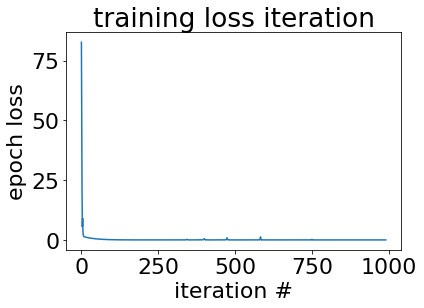

In [9]:
plt.plot(epoch_loss[10:])
plt.xlabel("iteration #")
plt.ylabel("epoch loss")
plt.title("training loss iteration")

## k-means clustering

Text(0.5, 0, 'count')

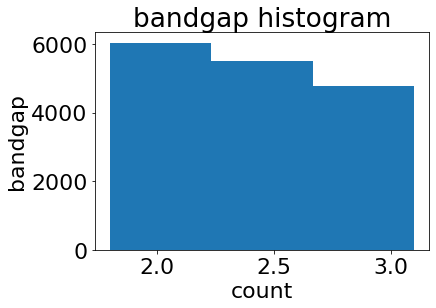

In [67]:
bins = plt.hist(Y, bins=3)
plt.title("bandgap histogram")
plt.ylabel("bandgap")
plt.xlabel("count")

In [68]:
class_boundary = bins[1]
def classify(y_i):
  
  n = len(class_boundary)
  for i in range(n-1):
    if y_i >= class_boundary[i] and y_i < class_boundary[i+1]:

      return i

y_class = [classify(yi[0]) for yi in Y]

Text(0, 0.5, 'class')

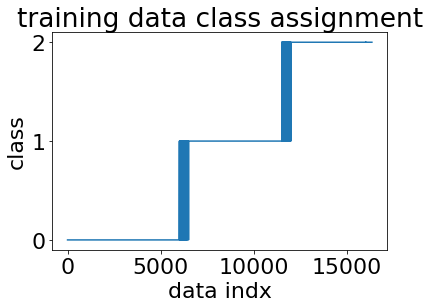

In [69]:
plt.plot(y_class)
plt.title("training data class assignment")
plt.xlabel("data indx")
plt.ylabel("class")

In [70]:
#train the clustering model
kmeans = KMeans(n_clusters=10, random_state=0).fit(X_train)
#classify each datapoint in testset to the trained clusters
pred_test_y_class = kmeans.predict(X_test)
test_y_class = [classify(yi[0]) for yi in y_test]

count = 0
for i_ in range(len(test_y_class)):
  if test_y_class[i_] == pred_test_y_class[i_]:
    count += 1
print("the resulting validation set classification accuracy is ", count/len(test_y_class))

the resulting validation set classification accuracy is  0.10893512851897184


## If I adopt this class assignment and build a neural network classifier on the data.

In [71]:
train_y_class = [classify(yi[0]) for yi in y_data]

In [81]:
#construct the neural network architecture
class Net_classifier(nn.Module):
    def __init__(self, input_size):
      super(Net_classifier, self).__init__()
      self.fc1 = nn.Linear(input_size, 64)
      self.fc2 = nn.Linear(64, 128)
      self.fc3 = nn.Linear(128, 64)
      self.fc4 = nn.Linear(64, 3)       
      self.dropout1 = nn.Dropout(p=0.1)

    def forward(self, x):
      x = self.fc1(x)
      x = F.relu(x)
      x = self.fc2(x)
      x = self.fc3(x)
      x = F.relu(x)
      x = self.fc4(x)
      return x

In [82]:
y_class_mat = []
for i in train_y_class:
  one_hot_encoder = np.zeros(3)
  one_hot_encoder[i] = 1
  y_class_mat.append(one_hot_encoder.copy())
y_class_mat = np.array(y_class_mat)
y_class_mat = torch.tensor(y_class_mat.astype(np.float32))

In [83]:
my_nn = Net_classifier(6)
y_class = np.array(y_class)
loss_fn = nn.MSELoss()
epoch_loss = []
model = my_nn
learning_rate = 0.02
optimizer = torch.optim.RMSprop(model.parameters(), lr=learning_rate, momentum=0.8)
for t in range(10000):
    y_pred = model(x_data)
    loss = loss_fn(y_pred, y_class_mat)
    epoch_loss.append(loss.item())
    if t % 100 == 99:
        print(t, loss.item())
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()



99 1.3743559122085571
199 0.8315625190734863
299 0.43279320001602173
399 0.2570953965187073
499 0.22299392521381378
599 0.22122569382190704
699 0.22121590375900269
799 0.22121590375900269
899 0.22121590375900269
999 0.22121593356132507
1099 0.22121593356132507
1199 0.22121593356132507
1299 0.22121590375900269
1399 0.22121590375900269
1499 0.22121593356132507
1599 0.22121590375900269
1699 0.22121590375900269
1799 0.22121590375900269
1899 0.22121761739253998
1999 0.22121666371822357
2099 0.22125299274921417
2199 0.22123247385025024
2299 0.22121934592723846
2399 0.2212330847978592
2499 0.22123326361179352
2599 0.22131504118442535
2699 0.22131741046905518
2799 0.22121743857860565
2899 0.2212206870317459
2999 0.22127731144428253
3099 0.2212742269039154
3199 0.2212361842393875
3299 0.22121849656105042
3399 0.22121761739253998
3499 0.22122305631637573
3599 0.2212301641702652
3699 0.2212897688150406
3799 0.22122037410736084
3899 0.22132597863674164
3999 0.22124314308166504
4099 0.2212268710136

In [84]:
class_test_result = my_nn(x_test)
predicted_class = torch.argmax(class_test_result, axis=1).numpy()

In [85]:
count = 0
for i_ in range(len(test_y_class)):
  if test_y_class[i_] == predicted_class[i_]:
    count += 1
print("the resulting validation set classification accuracy is ", count/len(test_y_class))

the resulting validation set classification accuracy is  0.3678090575275398


Text(0.5, 1.0, 'training loss iteration')

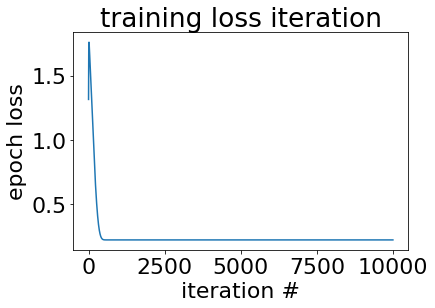

In [86]:
plt.plot(epoch_loss[10:])
plt.xlabel("iteration #")
plt.ylabel("epoch loss")
plt.title("training loss iteration")